In [2]:
import torch
import gpytorch
import numpy as np
import matplotlib.pyplot as plt
from src.plotting import plot_gp, plot_alpha_beta, plot_train_test_split

from src.data_loader import PVDataLoader
from src import data_loader as dl
from src.models import ExactGPModel, BetaGP

/Users/eirikbaekkelund/opt/anaconda3/envs/gp/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [110]:
# set seed
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

# data parameters
DAY_INIT = 20
DAY_MIN = 8
DAY_MAX = 16
N_DAYS = 5
MINUTE_INTERVAL = 5
DAILY_DATA_POINTS = (DAY_MAX - DAY_MIN) * 60 / MINUTE_INTERVAL
N_SYSTEMS = 30
RADIUS = 0.75
COORDS = (55.55074, -4.3278)
IDX = 6

In [111]:
loader = PVDataLoader(n_days=N_DAYS,
                    day_init=DAY_INIT,
                    n_systems=N_SYSTEMS,
                    radius=RADIUS,
                    coords=COORDS,
                    minute_interval=MINUTE_INTERVAL,
                    day_min=DAY_MIN,
                    day_max=DAY_MAX,
                    folder_name='pv_data',
                    file_name_pv='pv_data_clean.csv',
                    file_name_location='location_data_clean.csv')

time, y = loader.get_time_series()


==> Loading data
==> Loaded data in: 0 m : 11 sec

==> Loading data
==> Loaded data in: 0 m : 0 sec



# Stochastic Variational Inference for Gaussian Processes

Limitations:
- stochastic updates which can cause optimization problems and no guarantee of the global optimum is guaranteed, careful initialization and tuning of hyperparameters.
- not exact training data but inducing points (hyperparameter choice)
- not closed form solution for posterior s.t. solution is not exact


Strengths:
- non-gaussian likelihood for flexibility
- scalability
- uncertainty estimation
- approximate inference can capture important aspects of the underlying disitribtuions (giving fairly accurate predictions)

In [112]:
from gpytorch.distributions import base_distributions
class BetaLikelihood_MeanParametrization(gpytorch.likelihoods.BetaLikelihood):
	
	def forward(self, function_samples, *args, **kwargs):
		mixture = torch.tanh(function_samples) / 2 + 0.5
		self.scale = 80
		self.alpha = mixture * self.scale
		self.beta = self.scale - self.alpha

		eps = 1e-6
		
		self.alpha = self.alpha + eps
		self.beta = self.beta + eps
	
		return base_distributions.Beta(concentration1=self.alpha, concentration0=self.beta)

In [113]:
# TODO include in data loader

def periodic_mapping(time_steps, day_min, day_max, minute_interval):
    """ 
    Create a periodic mapping of time steps to a sine function to 
    capture the periodicity of the data.

    Args:
        time_steps (torch.Tensor): time steps to map
        day_min (int): minimum time of the day
        day_max (int): maximum time of the day
        minute_interval (int): interval between time steps in minutes

    Returns:
        torch.Tensor: mapped time steps to sine function
    """
    total_minutes = (day_max - day_min) * 60  # Total number of minutes in the specified time range
    normalized_minutes = (time_steps * minute_interval) % total_minutes  # Normalize time steps to minutes

    # Apply periodic mapping using sine function
    mapped_values = torch.sin(2 * torch.pi * normalized_minutes / total_minutes)
    
    return mapped_values


In [114]:
# get individual time series
y_in = y[:, IDX]

# get time related variables
periodic_time = periodic_mapping(time, DAY_MIN, DAY_MAX, MINUTE_INTERVAL)
x = torch.stack([time, periodic_time], dim=1)

# standardize input
x = (x - x.mean(dim=0)) / x.std(dim=0)

# split into train and test
x_train, y_train, x_test, y_test = dl.train_test_split(x, y_in, n_hours=3)

# use all data as inducing points
x_inducing = x_train
y_inducing = y_train

# Kernels

In [115]:
from gpytorch.kernels import MaternKernel, RBFKernel, ScaleKernel, AdditiveKernel, ProductKernel, PeriodicKernel
from gpytorch.means import ConstantMean
# TODO add a prior to the lengthscale in matern, and the period in periodic
# BEST INITS
# matern = MaternKernel(nu=5/2, ard_num_dims=x.shape[1], lengthscale_prior=gpytorch.priors.NormalPrior(1, 0.1))
# kernel = ScaleKernel(matern, lengthscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2))

matern = MaternKernel(nu=3/2, 
                      ard_num_dims=x.shape[1], 
                      lengthscale_prior=gpytorch.priors.NormalPrior(0.3, 0.1),
                      lengthscale_constraint=gpytorch.constraints.Positive()
                      )
scaled_matern = ScaleKernel(matern, 
                            outputscale_prior=gpytorch.priors.NormalPrior(0.5, 0.2),
                            outputscale_constraint=gpytorch.constraints.Positive()
                            )

In [116]:
jitter = 1e-4
config = {'type': 'stochastic',
          'name': 'mean_field',
          'num_inducing_points': x_inducing.size(0),
          'mean_init_std': 1,
}

inputs_mean = {'X': x_train, 'y': y_train, 
               'mean_module': gpytorch.means.ConstantMean(),'covar_module': scaled_matern,
               'likelihood': BetaLikelihood_MeanParametrization(scale_prior=gpytorch.priors.NormalPrior(30, 2),
                                                                scale_constraint=gpytorch.constraints.Interval(25, 200)),
                'config': config,
                'jitter': jitter
            }

model_beta = BetaGP(**inputs_mean)
model_beta.fit(n_iter=500, lr=0.1, optim=torch.optim.Adam, device=torch.device('cpu'))


Iter 50/500 - Loss: 1.605
Iter 100/500 - Loss: 0.340
Iter 150/500 - Loss: -0.203
Iter 200/500 - Loss: -0.346
Iter 250/500 - Loss: -0.423
Iter 300/500 - Loss: -0.475
Iter 350/500 - Loss: -0.512
Iter 400/500 - Loss: -0.536
Iter 450/500 - Loss: -0.550
Iter 500/500 - Loss: -0.559


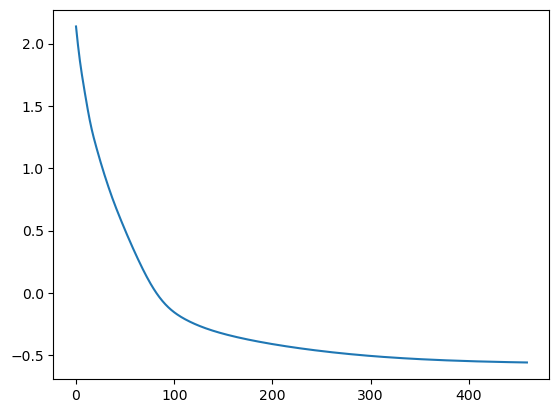

In [117]:
plt.plot(model_beta.losses[40:]);

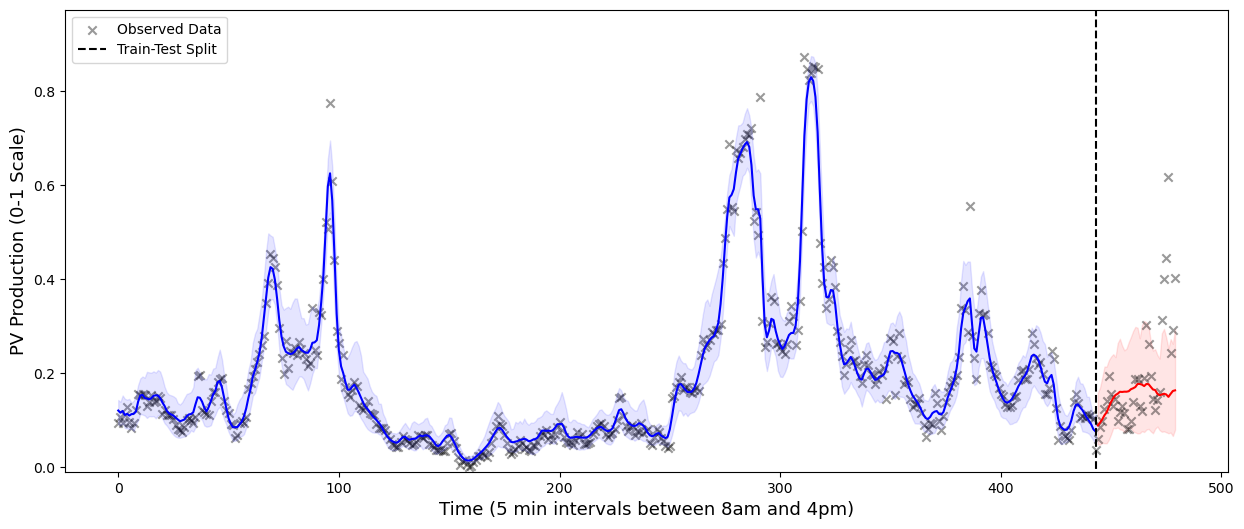

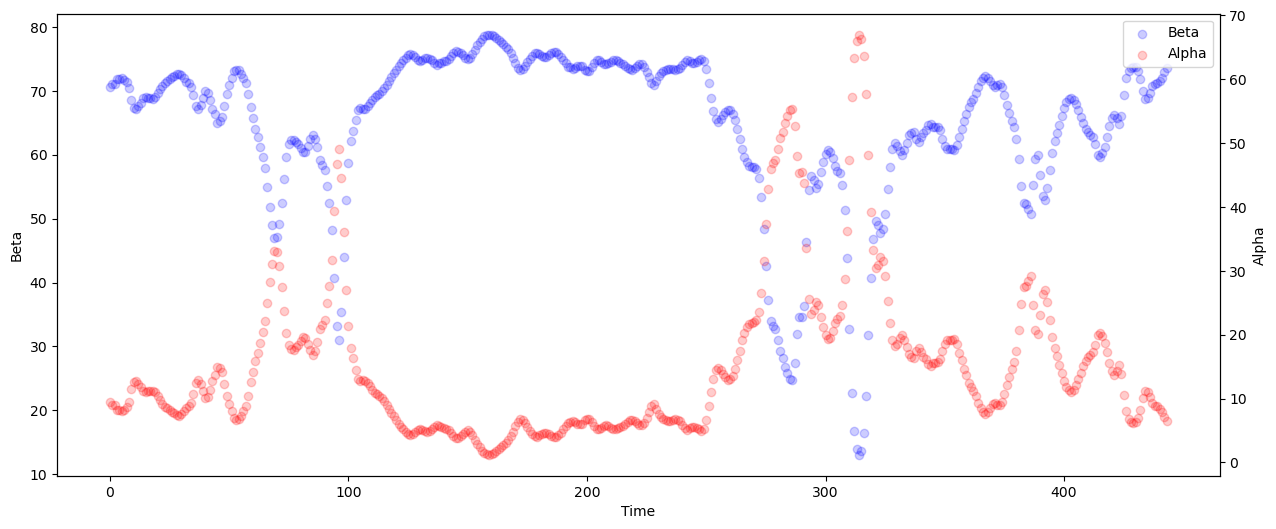

In [118]:
plot_gp(model=model_beta, 
        x_train=x_train,
        x_test=x_test,
        y_train=y_train,
        y_test=y_test,
        y_inducing=y_inducing,
        )

model_beta.predict(x_train, device=torch.device('cpu'))
plot_alpha_beta(model_beta)

In [104]:
model_beta.likelihood.scale.item()

80.00000762939453